# Edge detection

**Edges** are very important in human visual systems to distinguish objects


Edge can be defined as Place of rapid change in intensity 

#### Edges are caused by discontinuity of: 
 - Surface color/ appearance
 - Surface normal
 - Depth
 - Illumination

#### Why Edges?
 - Group pixels into objects or parts
 - To track important features (*corners, curves, lines*)
 - Cues for 3D shape
 - Guiding interactive image editing

### Propoerties:
- **Detection**
  - Find all real edge and ignore noise
- **Localization**
  - Detect edge close to true edge
- **Single response**
  - Return only one point for each true edge point

### Image Gradients

Gradient points the direction of the most rapid change in the intensity.

Gradient of an image is given by:
$$
\nabla f = [\frac{\partial f}{\partial x} , \frac{\partial f}{\partial y}]
$$

Gradient direction (Orientation of the edge normal) is given by:
$$
\theta = tan ^{-1} [\frac{\partial f}{\partial x} / \frac{\partial f}{\partial y}]
$$

Edge strength (Magnitude) is given by:
$$
|| \nabla f || = \sqrt{(\frac{\partial f}{\partial x})^2 + (\frac{\partial f}{\partial y})^2}
$$


We can approximate the partial derivative and one such approximation gives us Sobel Filter, which is widely used of edge detection, which is defined as:

\begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1\\
\end{bmatrix}
$$Sobel \space Filter$$


**Few other first order derivative filters are**:

\begin{bmatrix}
-1 & 0 & 1\\
-1 & 0 & 1\\
-1 & 0 & 1\\
\end{bmatrix}
$$Prewitt \space filter$$


\begin{bmatrix}
0 & 1\\
-1 & 0\\
\end{bmatrix}
$$Roberts \space filter$$

### Non Maxima Supression:
Used to thin out the edges, edges calculated using image gradient will output an image with thick edges, so in order to get fine thin edge we use non maximum supression

Non maxima supression is accomplished by checking if pixel is local maximum along the gradient

### Hystersis Thresholding
This technique uses two thresholds, namely high and low
 - High: Strat the edge
 - Low: Continue the edge 

If the gradient at pixel is
 - High(>): **Edge pixel**
 - Low(<): Non edge pixel
 - High & low(<=>): Edge pixel iff it is connected to an 'edge pixel' directly or via pixels between low and high

## Canny Edge Detection:
- Found by John Canny in 1986

### **Algorithm:**
1. Filter image with derivative of guassian
2. Find magnitude & orientation  of gradient
3. Non maximum supression
4. Linking & Thersholding (**Hystersis**):
 - Define two thresholds: **low** & **high**
   - High: Strat the edge
   - Low: Continue the edge 

**Original --> Smoothed --> Gradient Magnitudes --> edge after non maximum supression --> Double thresholding --> Edge tracking by hystersis --> Final Output**




## Implementation

In [34]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import seaborn as sns

In [35]:
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams["figure.autolayout"] = True

### Image smoothing with Gaussian blur

In [36]:
def GaussianBlur(img, filter=3):
    # This function will produce the gaussian blur of the given image
    # Create a Gaussian filter of the given kernel size
    filter = np.array([[1/16,2/16,1/16],[2/16,4/16,2/16],[1/16,2/16,1/16]])
    # Convolve the image with the gaussian filter to the gaussian blur
    return conv2D(img,filter)


### Convolution

Given a kernel of size (2k+1)x(2k+1), convoltion is defined as:
$$
G(i,j) = \sum_{u=-k}^{k} \sum_{u=-k}^{k} H(u,v) I(i-u,j-v)$$

In [37]:
def conv2D(img,filter, to_pad=True):
    # This function performs a 2D convolve on the given image with the given filter

    # Add Padding in order to get the input sized output image 
    if to_pad == True:
        padded = pad(img,filter)
    else:
        padded = img
    p = (filter.shape[0]-1)//2
    #Create the output matrix
    conv = np.zeros((img.shape[0],img.shape[1]))


    #Loop in the matrix for the size of the image
    for i in range(1,img.shape[0]-1):
        for j in range(1,img.shape[1]-1):

            # Convolve only if the y moved appropriate strides
            if j%p==0: #Stride

                #Convolution 
                # G(i,j) = sum(filter * Image(x,y))
                conv[i,j] = (filter* padded[i-1:i+2, j-1:j+2]).sum()


    # Return the convolved matrix
    return conv

#### Padding

**Padding**:
Our (n x n) image becomes (n + 2p) x (n + 2p) image after padding. So, applying convolution-operation (with (f x f) filter) outputs (n + 2p – f + 1) x (n + 2p – f + 1) images

[(n + 2p) x (n + 2p) image] * [(f x f) filter] —> [(n x n) image]

which gives p = (f – 1) / 2 (because n + 2p – f + 1 = n). 

In [38]:
#This Function add the padding to the input image, this function uses same padding([(n + 2p) x (n + 2p) image] * [(f x f) filter] —> [(n x n) image])
def pad(img,filter):
    
    #Get the number of pads to be added
    pad = (filter.shape[0]-1)//2

    #Create an array([(n + 2p) x (n + 2p)]) of zeros 
    padded = np.zeros((img.shape[0]+pad*2,img.shape[1]+pad*2))
    
    #Insert image in the center of the image of the array of zeros
    padded[pad:-pad,pad:-pad] = img

    #return the padded image and the numer of pads
    return padded

### Image Gradients

In [39]:
def Sobel(img, dx=1,dy=1,fsize=3):
    #Defing Sobel Filters
    filter_x = np.array(((-1,0,1),(-2,0,2),(-1,0,1)))
    filter_y = filter_x.transpose()
    
    #img , p = pad(img, filter_x)

    #Creating convolved image matrix
    conv = np.zeros(img.shape)

    # Creating f derivative w.r.t x and y matrix
    dx = conv2D(img,filter_x,False)
    dy = conv2D(img,filter_y,False)

    #Calculating the magnitude of the gradients
    conv = np.sqrt(np.square(dx)+np.square(dy))
    conv *= 255/np.max(conv)

    #np.arctan2(dy, dx) Computes element-wise arc tangent of dx/dy choosing the quadrant appropriately
    #Converting radians to degree --> (-180,180)
    direction = np.rad2deg(np.arctan2(dy, dx))  
    #Adding 180 to get the range to (0,180)
    direction[direction <0] += 180
    #conv = conv.astype('uint8')

    return conv, direction

### Second order derivative: Laplacian of Gaussian

In [40]:
def Laplacian(img,fsize=3):
    filter = np.array(((0,1,0),(1,-4,1),(0,1,0)))
    conv = conv2D(img,filter,False)
    conv /= np.max(conv)
    return conv

### Non Maximum Supression

In [41]:
def non_maxima_suppression(img, direction):
    supressed = np.zeros(img.shape)

    for i in range(1,img.shape[0]-1):
        for j in range(1,img.shape[1]-1):
            p = 255
            r = 255

            #Angle 0
            if (0<= direction[i,j]<22.5)or(157.5 <= direction[i,j]<=180):
                p = img[i,j-1]
                r = img[i,j+1]

            #Angle 45
            elif (22.5<=direction[i,j]<67.5):
                p = img[i-1,j+1]
                r = img[i+1,j-1]

            #Angle 90
            elif(67.5<=direction[i,j]<112.5):
                p = img[i-1,j]
                r = img[i+1,j]

            #Angle 135
            elif(112.5<=direction[i,j]<157.5):
                p = img[i-1,j-1]
                r = img[i+1,j+1]

            #Check if the pixel is larger than the adjacent pixels
            if (img[i,j]>=p and img[i,j]>=r):
                supressed[i,j] = img[i,j]
   
            else:
                supressed[i,j] = 0
                
    # Scalling the pixels to the maximum value
    supressed *= 255.0/supressed.max()
    return supressed


### Doouble thresholding and edge tracking using Hysteresis

In [42]:
def hystersis(img, low, high, weak=50,strong=255):
    
    #Creating new matrix of image size with zeros
    thresh_out = np.zeros(img.shape)

    #Finding the index where the pixel is higher than the high threshold
    strong_i, strong_j = np.where(img >= high)

    ##Finding the index where the pixel is lower than the low threshold
    weak_i, weak_j = np.where((img <= high) & (img >low))
    
    '''Assinging the values 255 and weak(i.e., given or 50 by default) to 
    indexes with strong values and weak values respectively'''
    thresh_out[strong_i,strong_j] = strong 
    thresh_out[weak_i,weak_j] = weak


    for i in range(1,img.shape[0]-1):
        for j in range(1,img.shape[1]-1):
           
            try:
                #Checking if the pixel is between the high and low threshold
                if (thresh_out[i,j] == weak):
                    #If the value is between the high and low threshold, then check if the neighboring pixel is an edge
                    if (thresh_out[i-1,j-1]==strong or thresh_out[i-1,j]==strong or thresh_out[i-1,j+1]==strong or thresh_out[i,j-1]==strong or thresh_out[i,j+1]==strong or thresh_out[i+1,j-1]==strong or thresh_out[i+1,j]==strong or thresh_out[i+1,j+1]==strong):
                        #If the neighboring pixel is an edge, then make this pixel an edge
                        thresh_out[i,j]=strong 
            except IndexError as e:
                pass

    #push all pixel values to 0 that are not an edge
    thresh_out[thresh_out!=strong] = 0

    
    return thresh_out

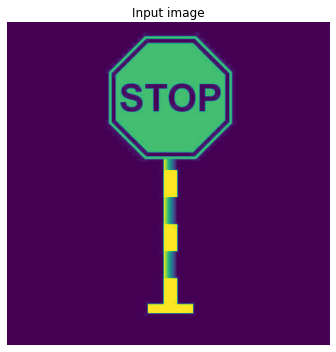

In [43]:
img = cv.imread('stop.jpg',0)
img = cv.bitwise_not(img)
plt.title("Input image")
plt.imshow(img)
plt.axis('off')
plt.show()


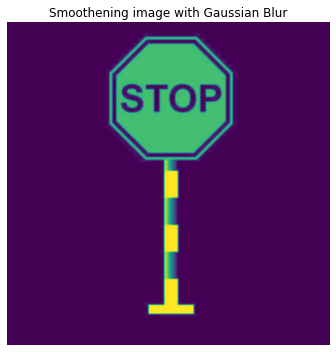

In [44]:
gaus = GaussianBlur(img)
plt.imshow(gaus)
plt.title("Smoothening image with Gaussian Blur")
plt.axis('off')
plt.show()

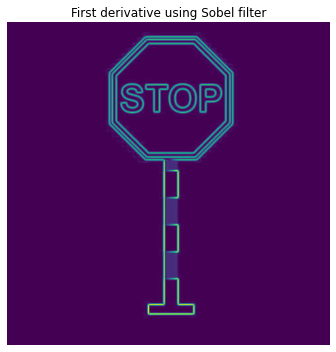

In [45]:
sobel, direction = Sobel(gaus)
plt.imshow(sobel)
plt.title("First derivative using Sobel filter")
plt.axis('off')
plt.show()


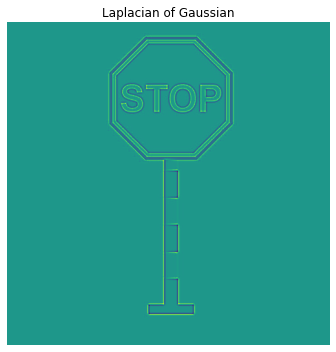

True

In [46]:
laplacian = Laplacian(gaus)
plt.imshow(laplacian)
plt.title("Laplacian of Gaussian")
plt.axis('off')
plt.show()
cv.imwrite("Nlaplacian.png",laplacian)

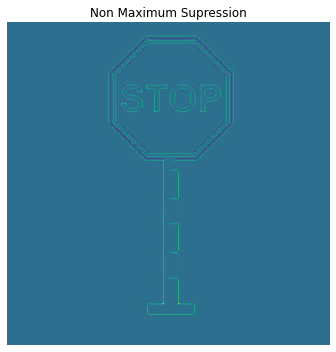

In [47]:
nms = non_maxima_suppression(laplacian,direction)
plt.imshow(nms)
plt.title("Non Maximum Supression")
plt.axis('off')
plt.show()
#cv.imwrite("nsm4.png",nms)

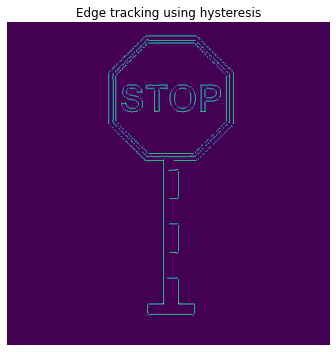

In [48]:
hyst = hystersis(nms,50,60)
plt.imshow(hyst)
plt.title("Edge tracking using hysteresis")
plt.axis('off')
plt.show()

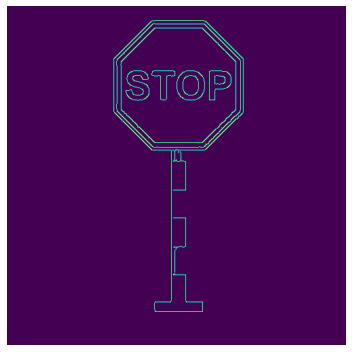

In [49]:
canny = cv.Canny(img,100,200)
plt.imshow(canny)

plt.axis('off')
plt.show()

### Few other examples

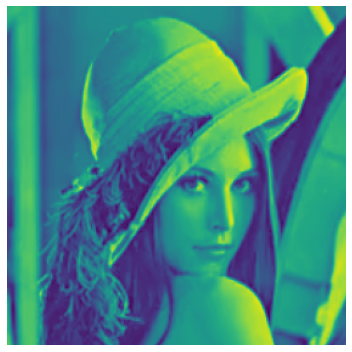

In [50]:
img = cv.imread("Lena.png",0)
plt.imshow(img)
plt.axis('off')
plt.show()

In [51]:
gaus = GaussianBlur(img)
sobel, direction = Sobel(gaus)
laplacian = Laplacian(gaus)
nms = non_maxima_suppression(sobel, direction)
hys = hystersis(nms,5,35)

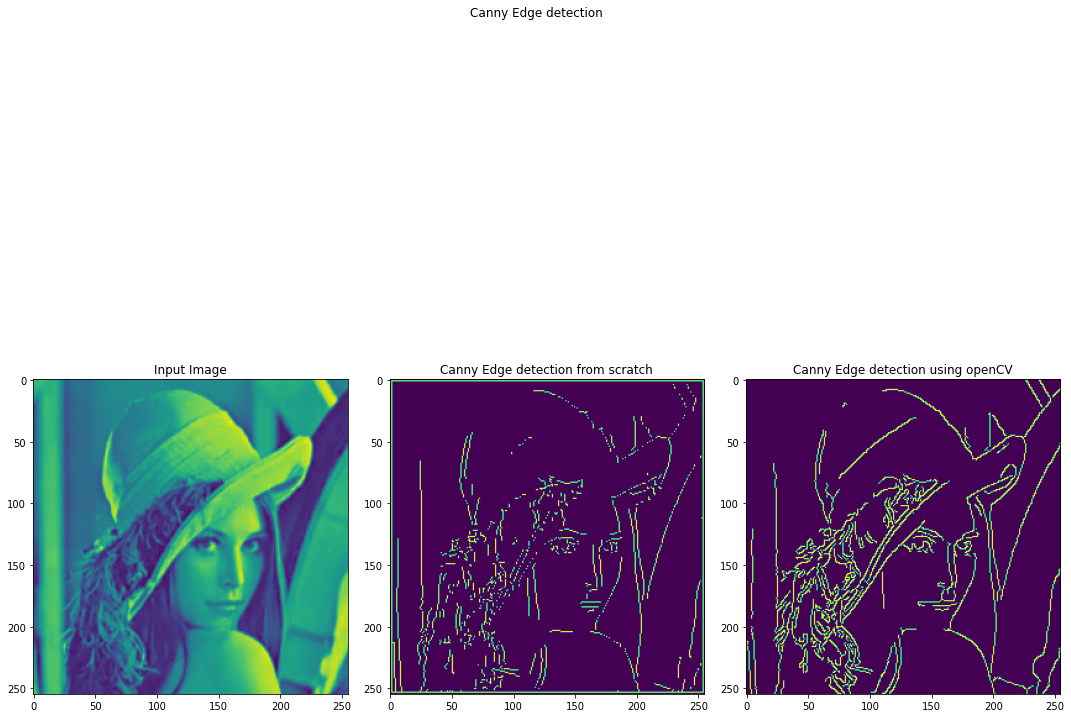

In [52]:
fig, ax = plt.subplots(1,3, figsize = (15,15))
ax[0].imshow(img)
#.axis("off")
ax[0].set_title("Input Image")
#plt.show()
ax[1].imshow(hys)
#plt.axis("off")
ax[1].set_title("Canny Edge detection from scratch")
#plt.show()
mr = cv.Canny(img,100,200)
ax[2].imshow(mr)
#plt.axis("off")
ax[2].set_title("Canny Edge detection using openCV")
#plt.show()
fig.suptitle("Canny Edge detection")
plt.show()

### Cardiac MRI


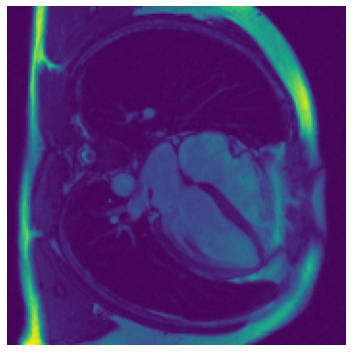

In [53]:
mri = cv.imread("0.png",0)
plt.imshow(mri)
plt.axis('off')
plt.show()

In [54]:

#img = cv.bitwise_not(mri)
gaus = GaussianBlur(mri)
sobel, direction = Sobel(gaus)
laplacian = Laplacian(gaus)
nms = non_maxima_suppression(sobel, direction)
hys = hystersis(nms,10,25)

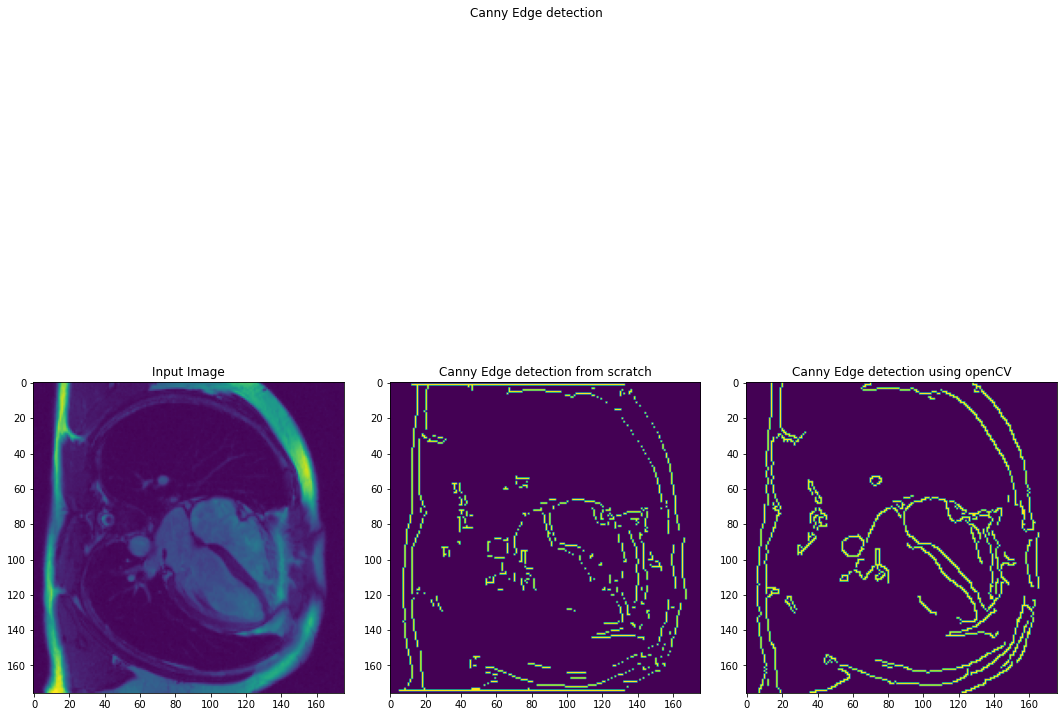

In [55]:
fig, ax = plt.subplots(1,3, figsize = (15,15))
ax[0].imshow(mri)
#.axis("off")
ax[0].set_title("Input Image")
#plt.show()
ax[1].imshow(hys)
#plt.axis("off")
ax[1].set_title("Canny Edge detection from scratch")
#plt.show()
mr = cv.Canny(mri,100,200)
ax[2].imshow(mr)
#plt.axis("off")
ax[2].set_title("Canny Edge detection using openCV")
#plt.show()
fig.suptitle("Canny Edge detection")
plt.show()

### References:
1. https://nptel.ac.in/courses/106106224 
2. https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html
3. https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/MORSE/edges.pdf
3. https://cse442-17f.github.io/Sobel-Laplacian-and-Canny-Edge-Detection-Algorithms/
5. https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
6. http://www.adeveloperdiary.com/data-science/computer-vision/implement-canny-edge-detector-using-python-from-scratch/
7. https://github.com/StefanPitur/Edge-detection---Canny-detector
8. https://gist.github.com/FienSoP/03ed9b0eab196dde7b66f452725a42ac
